In [1]:
import numpy as np
import jax.numpy as jnp
from jax import random, jit, jacfwd, vmap
from jax.numpy.linalg import inv
from jax.nn import tanh, sigmoid

from scipy.optimize import minimize
from scipy.stats import norm

import matplotlib.pyplot as plt

np.random.seed(1)

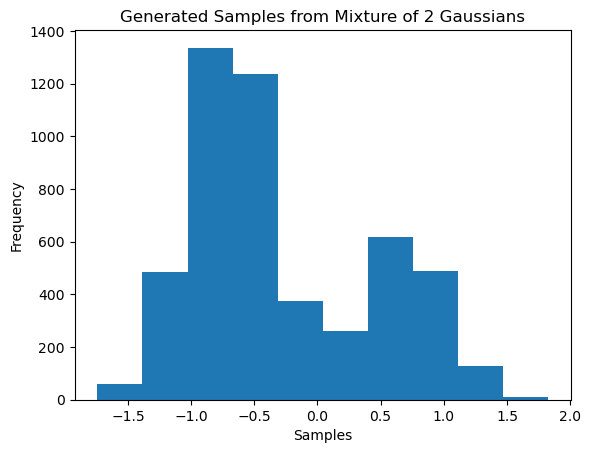

In [2]:
# Chat GPT generated code to sample from mixture of 2 2-dimensional Gaussians

# Generate samples from a 2-dimensional mixture of 2 Gaussians.
def generate_samples(num_samples, means, covariances, weights):
    num_components = len(means)

    # Choose components for each sample based on the weights
    component_choices = np.random.choice(num_components, size=num_samples, p=weights)

    # Generate samples for each component
    samples = np.zeros((num_samples, len(means[0])))

    for i in range(num_components):
        component_samples = np.random.multivariate_normal(means[i], covariances[i], size=num_samples)
        mask = (component_choices == i)
        samples[mask, :] = component_samples[mask, :]

    return samples

# Example usage:
# Set up parameters for two Gaussians
mean1 = np.array([-.7])
covariance1 = np.array([[.1]])
precision1 = inv(covariance1)
weight1 = .7

mean2 = np.array([.7])
covariance2 = np.array([[.1]])
precision2 = inv(covariance2)
weight2 = .3

# Generate synthetic data
num_samples = 5000
means = [mean1, mean2]
covariances = [covariance1, covariance2]
weights = [weight1, weight2]
generated_samples = generate_samples(num_samples, means, covariances, weights)

plt.hist(generated_samples.ravel())
plt.title('Generated Samples from Mixture of 2 Gaussians')
plt.xlabel('Samples')
plt.ylabel('Frequency')
plt.show()

In [3]:
# goal is to use a neural network to map Gaussian noise to samples from posterior parameter distribution

In [4]:
# problem dimension
d = 1

# neural net dimension
h1 = 2
# h2 = 2
# h3 = 2

# determine shapes of weights/biases = [Wih, bih, Who, bho]
# shapes = [[h1, d], [h1], [h2, h1], [h2], [h3, h2], [h3], [d, h3], [d]]
shapes = [[h1, d], [h1], [d, h1], [d]]
k_params = []
n_params = 0
for shape in shapes:
    k_params.append(n_params)
    n_params += np.prod(shape)
k_params.append(n_params)

# initialize parameters
lmbda = np.zeros(n_params)
for k1,k2,shape in zip(k_params, k_params[1:], shapes):
    if len(shape)>1:
        stdv = 2./np.sqrt(2*shape[-1])
        # lmbda[k1:k2] = np.random.uniform(0., stdv, k2-k1,)
        lmbda[k1:k2] = np.log2(np.random.uniform(0., stdv, k2-k1,))
    else:
        lmbda[k1:k2] = np.random.randn(k2-k1,) / np.sqrt(2.)
    
# reshape parameters into weight matrices and bias vectors
def reshape(params):
    # params is a vector = [Wih, bih, Who, bho]
    return [np.reshape(params[k1:k2], shape) for k1, k2, shape in
            zip(k_params, k_params[1:], shapes)]

@jit
def nn(y, lmbda):
    
    # weights and biases of nn
    W1, b1, W4, b4 = reshape(lmbda)
    
    # hidden layer
    h = tanh(jnp.einsum('ij,...j->...i', jnp.exp2(W1), y) + b1)
    
    # hidden layer
    # h = tanh(jnp.einsum('ij,...j->...i', jnp.exp2(W2), h) + b2)
    
    # hidden layer
    # h = tanh(jnp.einsum('ij,...j->...i', jnp.exp2(W3), h) + b3)
    
    # output
    z = jnp.einsum('ij,...j->...i', jnp.exp2(W4), h) + b4
    
    return z

# gradient of nn output w.r.t. parameters
grad_nn = jit(jacfwd(nn, 1))

# @jit 
# def inv_nn(z, lmbda):
    
#     # weights and biases of nn
#     W1, b1, W3, b3 = reshape(lmbda)
    
#     # hidden layer
#     h = jnp.einsum('ij,...j->...i', inv(W3), z - b3)
    
#     # input 
#     # h = jnp.einsum('ij,...j->...i', inv(W2), jnp.arctanh(h) - b2)
    
#     # input 
#     y = jnp.einsum('ij,...j->...i', inv(W1), jnp.arctanh(h) - b1)

#     return y 
    
# gradient of nn output w.r.t. parameters
jac_nn = jit(jacfwd(nn, 0))
# jac_inv_nn = jit(jacfwd(inv_nn, 0))

@jit
def log_abs_det(yi, lmbda):
    return jnp.log(jnp.abs(jnp.linalg.det(jac_nn(yi, lmbda))))

# gradient of entropy of approximating distribution w.r.t. lmbda
grad_log_abs_det = jit(jacfwd(log_abs_det, 1))

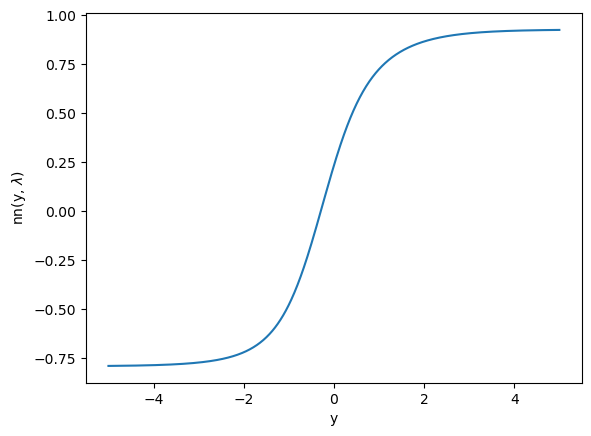

In [5]:
y = np.vstack(np.linspace(-5, 5, 1000))
z = nn(y, lmbda)

plt.plot(y.ravel(), np.array(z.ravel()))
plt.xlabel('y')
plt.ylabel('nn(y, $\lambda$)')
plt.show()

In [6]:
# nll of true posterior
@jit 
def neg_log_likelihood(yi, lmbda):
    zi = nn(yi, lmbda)
    # l1 = weight1 * N(zi | m1, C1)
    # l2 = weight2 * N(zi | m2, C2)
    l1 = weight1 * 1./((2.*jnp.pi)**(d/2.)) * (1./jnp.sqrt(jnp.linalg.det(covariance1))) * jnp.exp(-jnp.einsum('i,ij,j', zi-mean1, precision1, zi-mean1) / 2.)
    l2 = weight2 * 1./((2.*jnp.pi)**(d/2.)) * (1./jnp.sqrt(jnp.linalg.det(covariance2))) * jnp.exp(-jnp.einsum('i,ij,j', zi-mean2, precision2, zi-mean2) / 2.)
    return -jnp.log(l1 + l2)
grad_neg_log_likelihood = jit(jacfwd(neg_log_likelihood, 1))

# kl divergence btw q(lmbda) and p(z | X)
def kl(lmbda, n_sample=10):
    
    # use nn to sample parameters
    # y = np.random.random(size=[n_sample, d])
    y = np.random.randn(n_sample, d)
    z = nn(y, lmbda)
    
    # evaluate model fitness 
    KL = 0.
    for yi, zi in zip(y, z):
        # divergence btw true posterior
        KL += neg_log_likelihood(yi, lmbda) / n_sample
        # entropy
        KL -= log_abs_det(yi, lmbda) / n_sample
        
    return KL

# make sure NN is flexible enough to capture true posterior
def grad_kl(lmbda, n_sample=10):
    
    # use nn to sample parameters
    # y = np.random.random(size=[n_sample, d])
    y = np.random.randn(n_sample, d)
    z = nn(y, lmbda)
    
    grad_KL = 0.
    for yi, zi in zip(y, z):
        grad_KL += grad_neg_log_likelihood(yi, lmbda) / n_sample
        grad_KL -= grad_log_abs_det(yi, lmbda) / n_sample
        
    return grad_KL

In [7]:
# adam from chat gpt
def adam_optimizer(f, grad_f, initial_params, learning_rate=0.005, beta1=0.9, beta2=0.999, epsilon=1e-8, max_iterations=10000, tol=1e-6):
    """
    ADAM optimizer for minimizing a function.

    Parameters:
    - grad_f: Gradient function that returns the gradient of the objective function.
    - initial_params: Initial guess for the parameters.
    - learning_rate: Step size for the optimization (default: 0.001).
    - beta1: Exponential decay rate for the first moment estimate (default: 0.9).
    - beta2: Exponential decay rate for the second moment estimate (default: 0.999).
    - epsilon: Small constant to prevent division by zero (default: 1e-8).
    - max_iterations: Maximum number of iterations (default: 1000).
    - tol: Tolerance to stop optimization when the change in parameters is below this value (default: 1e-6).

    Returns:
    - Optimal parameters.
    """
    params = initial_params
    m = np.zeros_like(params)
    v = np.zeros_like(params)
    t = 0

    while t < max_iterations:
        t += 1
        
        if t%10==0:
            print("KL {:.3f}".format(f(params, n_sample=10)))

        gradient = grad_f(params)
        
        m = beta1 * m + (1 - beta1) * gradient
        v = beta2 * v + (1 - beta2) * (gradient ** 2)

        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)

        params -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

        if np.linalg.norm(learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)) < tol:
            break

    return params

In [8]:
lmbda = adam_optimizer(kl, grad_kl, lmbda)

KL 1.890
KL 2.096
KL 2.094
KL 1.382
KL 1.531
KL 1.555
KL 1.062
KL 1.846
KL 1.316
KL 1.535
KL 1.467
KL 1.539
KL 1.498
KL 1.645
KL 1.404
KL 1.373
KL 2.016
KL 1.199
KL 1.586
KL 1.391
KL 1.298
KL 1.610
KL 1.769
KL 1.413
KL 2.014
KL 1.159
KL 1.969
KL 1.810
KL 1.497
KL 1.521
KL 1.945
KL 1.702
KL 1.317
KL 1.989
KL 1.386
KL 1.825
KL 1.269
KL 1.704
KL 1.098
KL 1.289
KL 1.460
KL 1.449
KL 1.619
KL 1.273
KL 1.827
KL 2.034
KL 1.715
KL 1.393
KL 1.427
KL 1.226
KL 1.377
KL 1.787
KL 1.074
KL 1.446
KL 1.764
KL 2.218
KL 1.837
KL 1.446
KL 1.401
KL 1.358
KL 1.701
KL 1.872
KL 1.806
KL 1.832
KL 1.295
KL 1.358
KL 1.935
KL 1.752
KL 1.253
KL 1.763
KL 1.703
KL 1.546
KL 1.445
KL 1.581
KL 1.456
KL 1.477
KL 1.504
KL 1.415
KL 2.014
KL 1.495
KL 1.097
KL 1.476
KL 0.967
KL 1.634
KL 1.520
KL 1.152
KL 1.399
KL 1.108
KL 1.670
KL 1.686
KL 1.825
KL 1.395
KL 1.262
KL 1.630
KL 1.761
KL 1.363
KL 1.699
KL 1.909
KL 1.540
KL 2.490
KL 1.070
KL 1.384
KL 1.632
KL 0.922
KL 1.447
KL 1.659
KL 0.881
KL 1.973
KL 1.612
KL 2.045
KL 1.826
K

KL 1.294
KL 1.222
KL 1.223
KL 1.681
KL 1.483
KL 1.358
KL 1.360
KL 1.441
KL 1.477
KL 1.171
KL 1.366
KL 1.397
KL 1.345
KL 1.491
KL 1.933
KL 1.194
KL 1.350
KL 1.712
KL 1.657
KL 1.148
KL 1.940
KL 1.534
KL 1.041
KL 1.338
KL 1.641
KL 1.414
KL 1.161
KL 1.497
KL 1.384
KL 1.420
KL 1.299
KL 1.722
KL 1.413
KL 1.520
KL 1.572
KL 1.192
KL 1.565
KL 1.364
KL 1.749
KL 1.187
KL 1.316
KL 1.351
KL 1.228
KL 1.364
KL 1.293
KL 2.008
KL 1.396
KL 1.654
KL 1.406
KL 1.251
KL 1.550
KL 1.220
KL 1.189
KL 1.283
KL 1.264
KL 1.358
KL 1.299
KL 1.538
KL 1.250
KL 1.371
KL 1.365
KL 1.496
KL 1.255
KL 1.359
KL 1.342
KL 1.484
KL 1.795
KL 1.454
KL 1.223
KL 1.125
KL 1.278
KL 1.945
KL 1.508
KL 1.451
KL 1.333
KL 1.710
KL 1.306
KL 1.325
KL 1.140
KL 1.789
KL 1.292
KL 1.185
KL 1.320
KL 1.276


In [9]:
# sample noise
# y = np.random.random(size=[1000, d])
y = np.random.randn(5000, d)
z = nn(y, lmbda)

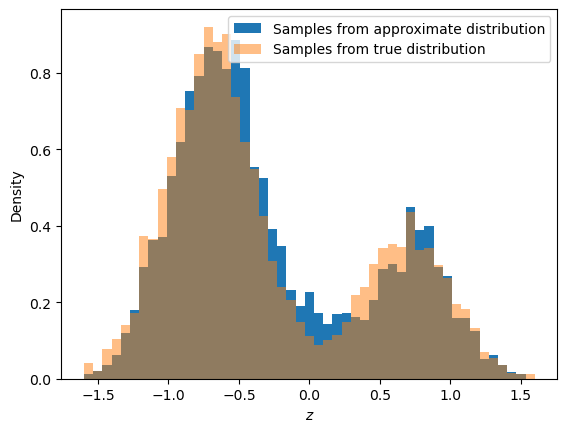

In [10]:
bins = np.linspace(-1.6, 1.6, 50)

plt.hist(np.array(z.ravel(), float), bins=bins, density=True, label='Samples from approximate distribution')
plt.hist(generated_samples.ravel(), bins=bins, alpha=.5, density=True, label="Samples from true distribution")
plt.xlabel('$z$')
plt.ylabel('Density')
plt.legend()
plt.show()

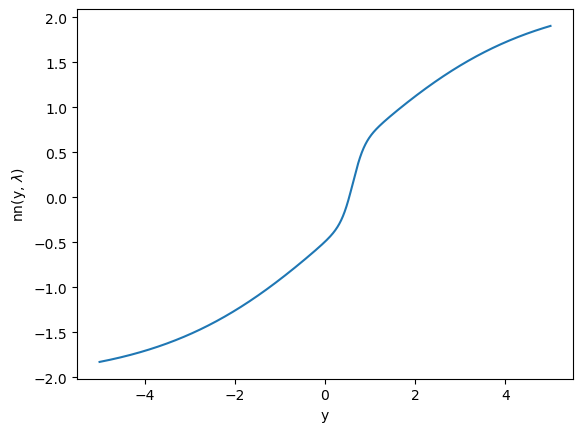

In [11]:
y = np.vstack(np.linspace(-5, 5, 1000))
z = nn(y, lmbda)

plt.plot(y.ravel(), np.array(z.ravel()))
plt.xlabel('y')
plt.ylabel('nn(y, $\lambda$)')
plt.show()

In [12]:
W1, b1, W4, b4 = reshape(lmbda)

In [16]:
W1

Array([[-1.9823431],
       [ 1.9866066]], dtype=float32)

In [14]:
W4

Array([[ 0.8028194, -1.377056 ]], dtype=float32)